# Quantum Tomography - analysis of Inclusive ALICE data

This is the analysis code to measure the polarisation of a vector meson using Quantum Tomography. The data here used were taken from HERA.

In [1]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
import pickle
import uproot
import numpy as np
import pandas as pd
# import xgboost as xgb
import sklearn

sys.path.insert(0, '../')
# import analysis_utils as au

# avoid pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Four-momentum logic

In [2]:
import skhep
from skhep import math


# Levi-Civita symbol
import sympy
from sympy import LeviCivita

Quantum tomography works by defining three coordinate axes in a Lorentz-invariant approach.

Using \\( k_+^\mu \\), \\(k_-^\mu \\) for the positive and the negative muon, respectively, we construct the vector meson 4-vector \\( Q^\mu \\) as:

\\[ Q^\mu = k_+^\mu + k_-^\mu \\]

If \\( p_A^\mu, p_B^\mu \\) are the two beams, the three axes \\( X^\mu, Y^\mu, Z^\mu \\) are defined as:

\\[ Z^\mu = p_A^\mu  Q{\cdot}p_B - p_B^\mu Q{\cdot}p_A \\]

\\[ Y^\mu = \epsilon^{\mu\nu\alpha\beta}p_{A \nu}p_{B \alpha}Q_\beta \\]

\\[ X^\mu = Q^\mu - p_A^\mu \frac{Q^2}{2Q{\cdot}p_A} - p_B^\mu \frac{Q^2}{2Q{\cdot}p_B} \\]





## Probe matrix
The probe matrix \\(\rho(l)\\) is defined as follows:
\\[\rho(l) = \frac{1+a}{3}\cdot \delta_{ij} - a{\cdot}l_i\cdot l_j - ib\cdot \epsilon_{ijk}\cdot l_k,\\]
where \\(a = 0.5\\) and \\(b = c_A{\cdot}c_V = \sin^2\theta_W \simeq 0.22\\).

In [3]:
from numpy import linalg as al
from numpy.linalg import eig as eig

In [4]:
#7    TeV pp  : https://arxiv.org/pdf/1111.1630.pdf
#8    TeV pp  : https://arxiv.org/pdf/1805.04374.pdf
#5.02 TeV PbPb: https://arxiv.org/pdf/2005.11128.pdf

data_inclusive = { 'E'             : [  7,     7,    7,     7,     7,     7,     8,      8,      8,      8,      8,      8,      8,      8,      8,      8,      8,      8    ],
                   'Frame'         : [  0,     0,    0,     1,     1,     1,     0,      0,      0,      0,      0,      0,      1,      1,      1,      1,      1,      1    ],
                   '<pT>'          : [  2.00,  3.00, 4.00,  2.00,  3.00,  4.00,  2.00,   3.00,   4.00,   5.00,   7.00,  10.00,   2.00,   3.00,   4.00,   5.00,   7.00,  10.00 ],
                   'Ltheta'        : [ -0.36, -0.20, 0.00, -0.10, -0.06, -0.09,  0.035, -0.085,  0.083, -0.036, -0.092, -0.329,  0.002, -0.011,  0.001,  0.063,  0.175, -0.021],
                   'Lphi'          : [  0.05,  0.01, 0.00, -0.04, -0.03,  0.03, -0.037, -0.065, -0.003,  0.055,  0.090, -0.003, -0.030, -0.065, -0.019, -0.020,  0.001, -0.052],
#                    'Lthetaphi'     : [  None,  None, None,  None,  None,  None, -0.024, -0.080, -0.024, -0.001,  0.089,  0.222,  0.041, -0.075,  0.006, -0.042, -0.009, -0.065],
                   'Lthetaphi'     : [  0,  0, 0,  0,  0,  0, -0.024, -0.080, -0.024, -0.001,  0.089,  0.222,  0.041, -0.075,  0.006, -0.042, -0.009, -0.065],
                   'StatLtheta'    : [  0.09,  0.11, 0.10,  0.14,  0.14,  0.10,  0.048,  0.053,  0.066,  0.058,  0.078,  0.121,  0.046,  0.052,  0.056,  0.048,  0.070,  0.110],
                   'StatLphi'      : [  0.04,  0.05, 0.04,  0.08,  0.08,  0.06,  0.025,  0.026,  0.033,  0.029,  0.039,  0.070,  0.024,  0.026,  0.030,  0.031,  0.045,  0.084],
#                    'StatLthetaphi' : [  None,  None, None,  None,  None,  None,  0.032,  0.035,  0.043,  0.039,  0.055,  0.099,  0.032,  0.035,  0.041,  0.041,  0.060,  0.110],
                   'StatLthetaphi' : [  0,  0, 0,  0,  0,  0,  0.032,  0.035,  0.043,  0.039,  0.055,  0.099,  0.032,  0.035,  0.041,  0.041,  0.060,  0.110],
                   'SysLtheta'     : [  0.21,  0.13, 0.10,  0.13,  0.07,  0.08,  0.215,  0.189,  0.188,  0.154,  0.168,  0.130,  0.228,  0.185,  0.124,  0.088,  0.096,  0.106],
                   'SysLphi'       : [  0.04,  0.05, 0.04,  0.07,  0.05,  0.07,  0.093,  0.134,  0.096,  0.069,  0.056,  0.052,  0.095,  0.098,  0.086,  0.087,  0.082,  0.077],
#                    'SysLthetaphi'  : [  None,  None, None,  None,  None,  None,  0.082,  0.077,  0.080,  0.078,  0.082,  0.079,  0.076,  0.084,  0.080,  0.082,  0.096,  0.098]                  
                   'SysLthetaphi'  : [  0,  0, 0,  0,  0,  0,  0.082,  0.077,  0.080,  0.078,  0.082,  0.079,  0.076,  0.084,  0.080,  0.082,  0.096,  0.098]                  

         } 
                                                                                                                        
                                                                                                                        
                                                                                                                        
                                      
df_inclusive = pd.DataFrame(data=data_inclusive)
df_inclusive

                
                                                                                                                        

,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,SysLphi,SysLthetaphi
0,7,0,2.0,-0.360,0.050,0.000,0.090,0.040,0.000,0.210,0.040,0.000
1,7,0,3.0,-0.200,0.010,0.000,0.110,0.050,0.000,0.130,0.050,0.000
2,7,0,4.0,0.000,0.000,0.000,0.100,0.040,0.000,0.100,0.040,0.000
3,7,1,2.0,-0.100,-0.040,0.000,0.140,0.080,0.000,0.130,0.070,0.000
4,7,1,3.0,-0.060,-0.030,0.000,0.140,0.080,0.000,0.070,0.050,0.000
5,7,1,4.0,-0.090,0.030,0.000,0.100,0.060,0.000,0.080,0.070,0.000
6,8,0,2.0,0.035,-0.037,-0.024,0.048,0.025,0.032,0.215,0.093,0.082
7,8,0,3.0,-0.085,-0.065,-0.080,0.053,0.026,0.035,0.189,0.134,0.077
8,8,0,4.0,0.083,-0.003,-0.024,0.066,0.033,0.043,0.188,0.096,0.080
9,8,0,5.0,-0.036,0.055,-0.001,0.058,0.029,0.039,0.154,0.069,0.078


In [5]:
def ConvertToRho33( LambdaTheta ):
    RhoZero = (1.-LambdaTheta)/(3. + LambdaTheta)
    return RhoZero

def ConvertToRho33Uncert( LambdaTheta, LambdaThetaUncert ):
    DeltaRhoZero = 4.*LambdaThetaUncert /((3. + LambdaTheta) * (3. + LambdaTheta))
    return DeltaRhoZero



def ConvertToRho22( LambdaTheta, LambdaPhi ):
    RhoTwo = (2.*LambdaPhi + LambdaTheta + 1.)/(3. + LambdaTheta)
    return RhoTwo

def ConvertToRho22Uncert( LambdaTheta, LambdaThetaUncert, LambdaPhi, LambdaPhiUncert ):
    DeltaRhoTwo = math.sqrt( (2.*LambdaPhi*LambdaThetaUncert/((3. + LambdaTheta)*(3. + LambdaTheta)))*(2.*LambdaPhi*LambdaThetaUncert/((3. + LambdaTheta)*(3. + LambdaTheta)))    +   ( 2.*LambdaPhiUncert/(3. + LambdaTheta) )*( 2.*LambdaPhiUncert/(3. + LambdaTheta) ))            
    return DeltaRhoTwo



def ConvertToRho13( LambdaTheta, LambdaThetaPhi ):
    RhoTwo = (-2.*LambdaThetaPhi)/(3. + LambdaTheta)
    return RhoTwo

def ConvertToRho13Uncert( LambdaTheta, LambdaThetaUncert, LambdaThetaPhi, LambdaThetaPhiUncert ):
    DeltaRho13 = math.sqrt( (2.*LambdaThetaPhiUncert/(3. + LambdaTheta))*(2.*LambdaThetaPhiUncert/(3. + LambdaTheta))    +   ( 2.*LambdaThetaPhi*LambdaThetaUncert/((3. + LambdaTheta)*(3. + LambdaTheta) ))*( 2.*LambdaThetaPhi*LambdaThetaUncert/((3. + LambdaTheta)*(3. + LambdaTheta) )           )   )         
    return DeltaRho13




def ConvertToRho11( LambdaTheta, LambdaThetaPhi ):
    Rho11 = (4.*LambdaThetaPhi*LambdaThetaPhi)/(3. - 2.*LambdaTheta - LambdaTheta*LambdaTheta)
    return Rho11

def ConvertToRho11Uncert( LambdaTheta, LambdaThetaUncert, LambdaThetaPhi, LambdaThetaPhiUncert ):
    A = (8.*LambdaThetaPhi*LambdaThetaPhiUncert/(3. - 2.*LambdaTheta - LambdaTheta*LambdaTheta))
    B = (4.*LambdaThetaPhi*LambdaThetaPhi*LambdaThetaUncert)*(-2.-LambdaTheta)/( (3. - 2.*LambdaTheta - LambdaTheta*LambdaTheta)*(3. - 2.*LambdaTheta - LambdaTheta*LambdaTheta) )
    DeltaRho11 = math.sqrt( A*A + B*B )
    return DeltaRho11


In [6]:
df_inclusive['Rho33']     = df_inclusive.apply(lambda x: ConvertToRho33(       x['Ltheta']                             ), axis=1)
df_inclusive['Rho22']     = df_inclusive.apply(lambda x: ConvertToRho22(       x['Ltheta'],      x['Lphi']             ), axis=1)
df_inclusive['Rho13']     = df_inclusive.apply(lambda x: ConvertToRho13(       x['Ltheta'],      x['Lthetaphi']        ), axis=1)
df_inclusive['Rho11']     = df_inclusive.apply(lambda x: ConvertToRho11(       x['Ltheta'],      x['Lthetaphi']        ), axis=1)
df_inclusive['Rho33stat'] = df_inclusive.apply(lambda x: ConvertToRho33Uncert( x['Ltheta'],      x['StatLtheta']       ), axis=1)
df_inclusive['Rho33sys']  = df_inclusive.apply(lambda x: ConvertToRho33Uncert( x['Ltheta'],      x['SysLtheta']        ), axis=1)
df_inclusive['Rho22stat'] = df_inclusive.apply(lambda x: ConvertToRho22Uncert( x['Ltheta'],      x['StatLtheta'],  x['Lphi'],           x['StatLphi']       ), axis=1)
df_inclusive['Rho22sys']  = df_inclusive.apply(lambda x: ConvertToRho22Uncert( x['Ltheta'],      x['SysLtheta'],   x['Lphi'],           x['SysLphi']        ), axis=1)
df_inclusive['Rho13stat'] = df_inclusive.apply(lambda x: ConvertToRho13Uncert( x['Ltheta'],      x['StatLtheta'],  x['Lthetaphi'],      x['StatLthetaphi']  ), axis=1)
df_inclusive['Rho13sys']  = df_inclusive.apply(lambda x: ConvertToRho13Uncert( x['Ltheta'],      x['SysLtheta'],   x['Lthetaphi'],      x['SysLthetaphi']   ), axis=1)
df_inclusive['Rho11stat'] = df_inclusive.apply(lambda x: ConvertToRho11Uncert( x['Ltheta'],      x['StatLtheta'],  x['Lthetaphi'],      x['StatLthetaphi']  ), axis=1)
df_inclusive['Rho11sys']  = df_inclusive.apply(lambda x: ConvertToRho11Uncert( x['Ltheta'],      x['SysLtheta'],   x['Lthetaphi'],      x['SysLthetaphi']   ), axis=1)

df_inclusive






,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho13,Rho11,Rho33stat,Rho33sys,Rho22stat,Rho22sys,Rho13stat,Rho13sys,Rho11stat,Rho11sys
0,7,0,2.0,-0.360,0.050,0.000,0.090,0.040,0.000,0.210,...,-0.000000,0.000000,0.051653,0.120523,0.030331,0.030452,0.000000,0.000000,0.000000,0.000000
1,7,0,3.0,-0.200,0.010,0.000,0.110,0.050,0.000,0.130,...,-0.000000,0.000000,0.056122,0.066327,0.035715,0.035716,0.000000,0.000000,0.000000,0.000000
2,7,0,4.0,0.000,0.000,0.000,0.100,0.040,0.000,0.100,...,-0.000000,0.000000,0.044444,0.044444,0.026667,0.026667,0.000000,0.000000,0.000000,0.000000
3,7,1,2.0,-0.100,-0.040,0.000,0.140,0.080,0.000,0.130,...,-0.000000,0.000000,0.066587,0.061831,0.055188,0.048292,0.000000,0.000000,0.000000,0.000000
4,7,1,3.0,-0.060,-0.030,0.000,0.140,0.080,0.000,0.070,...,-0.000000,0.000000,0.064788,0.032394,0.054430,0.034017,0.000000,0.000000,0.000000,0.000000
5,7,1,4.0,-0.090,0.030,0.000,0.100,0.060,0.000,0.080,...,-0.000000,0.000000,0.047236,0.037789,0.041243,0.048113,0.000000,0.000000,0.000000,0.000000
6,8,0,2.0,0.035,-0.037,-0.024,0.048,0.025,0.032,0.215,...,0.015815,0.000787,0.020844,0.093364,0.016479,0.061309,0.021089,0.054048,0.002098,0.005377
7,8,0,3.0,-0.085,-0.065,-0.080,0.053,0.026,0.035,0.189,...,0.054889,0.008094,0.024949,0.088970,0.017857,0.091984,0.024034,0.052950,0.007087,0.015609
8,8,0,4.0,0.083,-0.003,-0.024,0.066,0.033,0.043,0.188,...,0.015569,0.000815,0.027775,0.079117,0.021408,0.062277,0.027897,0.051906,0.002921,0.005434
9,8,0,5.0,-0.036,0.055,-0.001,0.058,0.029,0.039,0.154,...,0.000675,0.000001,0.026408,0.070117,0.019582,0.046599,0.026316,0.052632,0.000102,0.000203


In [7]:
# pip install --upgrade uncertainties
import uncertainties

In [8]:
df_inclusive['Rho33totaluncert']    = df_inclusive.apply(lambda x: math.sqrt( x['Rho33stat']*x['Rho33stat'] + x['Rho33sys']*x['Rho33sys'] ), axis=1)
df_inclusive['Rho22totaluncert']    = df_inclusive.apply(lambda x: math.sqrt( x['Rho22stat']*x['Rho22stat'] + x['Rho22sys']*x['Rho22sys'] ), axis=1)
df_inclusive['Rho13totaluncert']    = df_inclusive.apply(lambda x: math.sqrt( x['Rho13stat']*x['Rho13stat'] + x['Rho13sys']*x['Rho13sys'] ), axis=1)
df_inclusive['Rho11totaluncert']    = df_inclusive.apply(lambda x: math.sqrt( x['Rho11stat']*x['Rho11stat'] + x['Rho11sys']*x['Rho11sys'] ), axis=1)

df_inclusive['Rho33withuncert']     = df_inclusive.apply(lambda x: uncertainties.ufloat( x['Rho33'], x['Rho33totaluncert'] ), axis=1)
df_inclusive['Rho22withuncert']     = df_inclusive.apply(lambda x: uncertainties.ufloat( x['Rho22'], x['Rho22totaluncert'] ), axis=1)
df_inclusive['Rho13withuncert']     = df_inclusive.apply(lambda x: uncertainties.ufloat( x['Rho13'], x['Rho13totaluncert'] ), axis=1)
df_inclusive['Rho11withuncert']     = df_inclusive.apply(lambda x: uncertainties.ufloat( x['Rho11'], x['Rho11totaluncert'] ), axis=1)

df_inclusive

,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho11stat,Rho11sys,Rho33totaluncert,Rho22totaluncert,Rho13totaluncert,Rho11totaluncert,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert
0,7,0,2.0,-0.360,0.050,0.000,0.090,0.040,0.000,0.210,...,0.000000,0.000000,0.131126,0.042980,0.000000,0.000000,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.0+/-0
1,7,0,3.0,-0.200,0.010,0.000,0.110,0.050,0.000,0.130,...,0.000000,0.000000,0.086885,0.050509,0.000000,0.000000,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.0+/-0
2,7,0,4.0,0.000,0.000,0.000,0.100,0.040,0.000,0.100,...,0.000000,0.000000,0.062854,0.037712,0.000000,0.000000,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.0+/-0
3,7,1,2.0,-0.100,-0.040,0.000,0.140,0.080,0.000,0.130,...,0.000000,0.000000,0.090868,0.073334,0.000000,0.000000,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.0+/-0
4,7,1,3.0,-0.060,-0.030,0.000,0.140,0.080,0.000,0.070,...,0.000000,0.000000,0.072435,0.064186,0.000000,0.000000,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.0+/-0
5,7,1,4.0,-0.090,0.030,0.000,0.100,0.060,0.000,0.080,...,0.000000,0.000000,0.060492,0.063371,0.000000,0.000000,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.0+/-0
6,8,0,2.0,0.035,-0.037,-0.024,0.048,0.025,0.032,0.215,...,0.002098,0.005377,0.095663,0.063485,0.058016,0.005772,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.001+/-0.006
7,8,0,3.0,-0.085,-0.065,-0.080,0.053,0.026,0.035,0.189,...,0.007087,0.015609,0.092402,0.093701,0.058149,0.017142,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.008+/-0.017
8,8,0,4.0,0.083,-0.003,-0.024,0.066,0.033,0.043,0.188,...,0.002921,0.005434,0.083851,0.065854,0.058928,0.006169,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.001+/-0.006
9,8,0,5.0,-0.036,0.055,-0.001,0.058,0.029,0.039,0.154,...,0.000102,0.000203,0.074925,0.050546,0.058844,0.000227,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.00000+/-0.00023


In [9]:
def ProbeMatrix( Rho11, Rho13, Rho22, Rho33, returnValue ):
    rho       = np.array([[0.,0.,0.], [0.,0.,0.], [0.,0.,0.]])
    rho[0][0] = Rho11
    rho[0][2] = Rho13
    rho[2][0] = Rho13
    rho[1][1] = Rho22
    rho[2][2] = Rho33
    if returnValue == 0:
        return rho 
    elif returnValue == 1:
        return rho[0][0]
    elif returnValue == 2:
        return rho[0][1]
    elif returnValue == 3:
        return rho[0][2]
    elif returnValue == 4:
        return rho[0][3]
    elif returnValue == 5:
        return rho[1][0]
    elif returnValue == 6:
        return rho[1][1]
    elif returnValue == 7:
        return rho[1][2]
    elif returnValue == 8:
        return rho[2][0]
    elif returnValue == 9:
        return rho[2][1]
    elif returnValue == 10:
        return rho[2][2]



In [10]:
df_inclusive['ProbeMatrix'] = df_inclusive.apply(lambda x: ProbeMatrix( x['Rho11'], x['Rho13'], x['Rho22'], x['Rho33'], 0 ), axis=1)
df_inclusive



,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho11sys,Rho33totaluncert,Rho22totaluncert,Rho13totaluncert,Rho11totaluncert,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix
0,7,0,2.0,-0.360,0.050,0.000,0.090,0.040,0.000,0.210,...,0.000000,0.131126,0.042980,0.000000,0.000000,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2803030303030303, 0..."
1,7,0,3.0,-0.200,0.010,0.000,0.110,0.050,0.000,0.130,...,0.000000,0.086885,0.050509,0.000000,0.000000,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29285714285714287, ..."
2,7,0,4.0,0.000,0.000,0.000,0.100,0.040,0.000,0.100,...,0.000000,0.062854,0.037712,0.000000,0.000000,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0..."
3,7,1,2.0,-0.100,-0.040,0.000,0.140,0.080,0.000,0.130,...,0.000000,0.090868,0.073334,0.000000,0.000000,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2827586206896552, 0..."
4,7,1,3.0,-0.060,-0.030,0.000,0.140,0.080,0.000,0.070,...,0.000000,0.072435,0.064186,0.000000,0.000000,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29931972789115646, ..."
5,7,1,4.0,-0.090,0.030,0.000,0.100,0.060,0.000,0.080,...,0.000000,0.060492,0.063371,0.000000,0.000000,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0..."
6,8,0,2.0,0.035,-0.037,-0.024,0.048,0.025,0.032,0.215,...,0.005377,0.095663,0.063485,0.058016,0.005772,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.001+/-0.006,"[[0.0007866770236703058, 0.0, 0.01581548599670..."
7,8,0,3.0,-0.085,-0.065,-0.080,0.053,0.026,0.035,0.189,...,0.015609,0.092402,0.093701,0.058149,0.017142,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.008+/-0.017,"[[0.008094157820268594, 0.0, 0.054888507718696..."
8,8,0,4.0,0.083,-0.003,-0.024,0.066,0.033,0.043,0.188,...,0.005434,0.083851,0.065854,0.058928,0.006169,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.001+/-0.006,"[[0.0008149662323127745, 0.0, 0.01556925072980..."
9,8,0,5.0,-0.036,0.055,-0.001,0.058,0.029,0.039,0.154,...,0.000203,0.074925,0.050546,0.058844,0.000227,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.00000+/-0.00023,"[[1.30263288158025e-06, 0.0, 0.000674763832658..."


In [11]:
# df_inclusive_subset = df_inclusive.loc[6:17, :]
df_inclusive_subset = df_inclusive
df_inclusive_subset[['EigValues','EigVecs']] = df_inclusive_subset.apply(lambda x: eig(x['ProbeMatrix']  ), axis=1, result_type="expand")
df_inclusive_subset



,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho22totaluncert,Rho13totaluncert,Rho11totaluncert,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs
0,7,0,2.0,-0.360,0.050,0.000,0.090,0.040,0.000,0.210,...,0.042980,0.000000,0.000000,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2803030303030303, 0...","[0.0, 0.2803030303030303, 0.515151515151515]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
1,7,0,3.0,-0.200,0.010,0.000,0.110,0.050,0.000,0.130,...,0.050509,0.000000,0.000000,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29285714285714287, ...","[0.0, 0.29285714285714287, 0.4285714285714286]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
2,7,0,4.0,0.000,0.000,0.000,0.100,0.040,0.000,0.100,...,0.037712,0.000000,0.000000,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3333333333333333]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
3,7,1,2.0,-0.100,-0.040,0.000,0.140,0.080,0.000,0.130,...,0.073334,0.000000,0.000000,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2827586206896552, 0...","[0.0, 0.2827586206896552, 0.37931034482758624]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
4,7,1,3.0,-0.060,-0.030,0.000,0.140,0.080,0.000,0.070,...,0.064186,0.000000,0.000000,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29931972789115646, ...","[0.0, 0.29931972789115646, 0.36054421768707484]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
5,7,1,4.0,-0.090,0.030,0.000,0.100,0.060,0.000,0.080,...,0.063371,0.000000,0.000000,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3745704467353952]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ..."
6,8,0,2.0,0.035,-0.037,-0.024,0.048,0.025,0.032,0.215,...,0.063485,0.058016,0.005772,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.001+/-0.006,"[[0.0007866770236703058, 0.0, 0.01581548599670...","[0.0, 0.3187438434157625, 0.31663920922570016]","[[-0.9987652106382785, -0.049679513068018016, ..."
7,8,0,3.0,-0.085,-0.065,-0.080,0.053,0.026,0.035,0.189,...,0.093701,0.058149,0.017142,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.008+/-0.017,"[[0.008094157820268594, 0.0, 0.054888507718696...","[5.551115123125783e-17, 0.38030685078767856, 0...","[[-0.9893011528018606, -0.1458877276021177, 0...."
8,8,0,4.0,0.083,-0.003,-0.024,0.066,0.033,0.043,0.188,...,0.065854,0.058928,0.006169,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.001+/-0.006,"[[0.0008149662323127745, 0.0, 0.01556925072980...","[-5.551115123125783e-17, 0.2982525270496984, 0...","[[-0.9986328301723268, -0.0522730380024773, 0...."
9,8,0,5.0,-0.036,0.055,-0.001,0.058,0.029,0.039,0.154,...,0.050546,0.058844,0.000227,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.00000+/-0.00023,"[[1.30263288158025e-06, 0.0, 0.000674763832658...","[-5.551115123125783e-17, 0.3495289679500206, 0...","[[-0.9999981365863567, -0.0019304983331782945,..."


In [12]:
def UnpackEigValues(x, i):
    if i == 0:
        return x[0]
    if i == 1:
        return x[1]
    if i == 2:
        return x[2]
    

In [13]:
df_inclusive_subset['EigValuesReal_0'] = df_inclusive_subset.apply(lambda x: UnpackEigValues( x['EigValues'], 0 ), axis=1)
df_inclusive_subset['EigValuesReal_1'] = df_inclusive_subset.apply(lambda x: UnpackEigValues( x['EigValues'], 1 ), axis=1)
df_inclusive_subset['EigValuesReal_2'] = df_inclusive_subset.apply(lambda x: UnpackEigValues( x['EigValues'], 2 ), axis=1)
df_inclusive_subset


,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2
0,7,0,2.0,-0.360,0.050,0.000,0.090,0.040,0.000,0.210,...,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2803030303030303, 0...","[0.0, 0.2803030303030303, 0.515151515151515]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.280303,0.515152
1,7,0,3.0,-0.200,0.010,0.000,0.110,0.050,0.000,0.130,...,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29285714285714287, ...","[0.0, 0.29285714285714287, 0.4285714285714286]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.292857,0.428571
2,7,0,4.0,0.000,0.000,0.000,0.100,0.040,0.000,0.100,...,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3333333333333333]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.333333,0.333333
3,7,1,2.0,-0.100,-0.040,0.000,0.140,0.080,0.000,0.130,...,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2827586206896552, 0...","[0.0, 0.2827586206896552, 0.37931034482758624]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.282759,0.379310
4,7,1,3.0,-0.060,-0.030,0.000,0.140,0.080,0.000,0.070,...,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29931972789115646, ...","[0.0, 0.29931972789115646, 0.36054421768707484]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.299320,0.360544
5,7,1,4.0,-0.090,0.030,0.000,0.100,0.060,0.000,0.080,...,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3745704467353952]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.333333,0.374570
6,8,0,2.0,0.035,-0.037,-0.024,0.048,0.025,0.032,0.215,...,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.001+/-0.006,"[[0.0007866770236703058, 0.0, 0.01581548599670...","[0.0, 0.3187438434157625, 0.31663920922570016]","[[-0.9987652106382785, -0.049679513068018016, ...",0.000000e+00,0.318744,0.316639
7,8,0,3.0,-0.085,-0.065,-0.080,0.053,0.026,0.035,0.189,...,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.008+/-0.017,"[[0.008094157820268594, 0.0, 0.054888507718696...","[5.551115123125783e-17, 0.38030685078767856, 0...","[[-0.9893011528018606, -0.1458877276021177, 0....",5.551115e-17,0.380307,0.269297
8,8,0,4.0,0.083,-0.003,-0.024,0.066,0.033,0.043,0.188,...,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.001+/-0.006,"[[0.0008149662323127745, 0.0, 0.01556925072980...","[-5.551115123125783e-17, 0.2982525270496984, 0...","[[-0.9986328301723268, -0.0522730380024773, 0....",-5.551115e-17,0.298253,0.349335
9,8,0,5.0,-0.036,0.055,-0.001,0.058,0.029,0.039,0.154,...,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.00000+/-0.00023,"[[1.30263288158025e-06, 0.0, 0.000674763832658...","[-5.551115123125783e-17, 0.3495289679500206, 0...","[[-0.9999981365863567, -0.0019304983331782945,...",-5.551115e-17,0.349529,0.362348


In [14]:
df_inclusive

,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho33withuncert,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2
0,7,0,2.0,-0.360,0.050,0.000,0.090,0.040,0.000,0.210,...,0.52+/-0.13,0.28+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2803030303030303, 0...","[0.0, 0.2803030303030303, 0.515151515151515]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.280303,0.515152
1,7,0,3.0,-0.200,0.010,0.000,0.110,0.050,0.000,0.130,...,0.43+/-0.09,0.29+/-0.05,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29285714285714287, ...","[0.0, 0.29285714285714287, 0.4285714285714286]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.292857,0.428571
2,7,0,4.0,0.000,0.000,0.000,0.100,0.040,0.000,0.100,...,0.33+/-0.06,0.33+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3333333333333333]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.333333,0.333333
3,7,1,2.0,-0.100,-0.040,0.000,0.140,0.080,0.000,0.130,...,0.38+/-0.09,0.28+/-0.07,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2827586206896552, 0...","[0.0, 0.2827586206896552, 0.37931034482758624]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.282759,0.379310
4,7,1,3.0,-0.060,-0.030,0.000,0.140,0.080,0.000,0.070,...,0.36+/-0.07,0.30+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29931972789115646, ...","[0.0, 0.29931972789115646, 0.36054421768707484]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.299320,0.360544
5,7,1,4.0,-0.090,0.030,0.000,0.100,0.060,0.000,0.080,...,0.37+/-0.06,0.33+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3745704467353952]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.333333,0.374570
6,8,0,2.0,0.035,-0.037,-0.024,0.048,0.025,0.032,0.215,...,0.32+/-0.10,0.32+/-0.06,0.02+/-0.06,0.001+/-0.006,"[[0.0007866770236703058, 0.0, 0.01581548599670...","[0.0, 0.3187438434157625, 0.31663920922570016]","[[-0.9987652106382785, -0.049679513068018016, ...",0.000000e+00,0.318744,0.316639
7,8,0,3.0,-0.085,-0.065,-0.080,0.053,0.026,0.035,0.189,...,0.37+/-0.09,0.27+/-0.09,0.05+/-0.06,0.008+/-0.017,"[[0.008094157820268594, 0.0, 0.054888507718696...","[5.551115123125783e-17, 0.38030685078767856, 0...","[[-0.9893011528018606, -0.1458877276021177, 0....",5.551115e-17,0.380307,0.269297
8,8,0,4.0,0.083,-0.003,-0.024,0.066,0.033,0.043,0.188,...,0.30+/-0.08,0.35+/-0.07,0.02+/-0.06,0.001+/-0.006,"[[0.0008149662323127745, 0.0, 0.01556925072980...","[-5.551115123125783e-17, 0.2982525270496984, 0...","[[-0.9986328301723268, -0.0522730380024773, 0....",-5.551115e-17,0.298253,0.349335
9,8,0,5.0,-0.036,0.055,-0.001,0.058,0.029,0.039,0.154,...,0.35+/-0.07,0.36+/-0.05,0.00+/-0.06,0.00000+/-0.00023,"[[1.30263288158025e-06, 0.0, 0.000674763832658...","[-5.551115123125783e-17, 0.3495289679500206, 0...","[[-0.9999981365863567, -0.0019304983331782945,...",-5.551115e-17,0.349529,0.362348


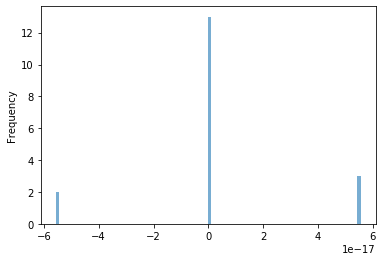

In [15]:
df_inclusive_subset['EigValuesReal_0'].plot.hist(bins=100, alpha=0.6)

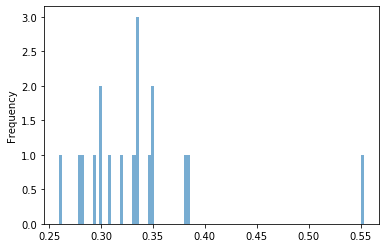

In [16]:
df_inclusive_subset['EigValuesReal_1'].plot.hist(bins=100, alpha=0.6)

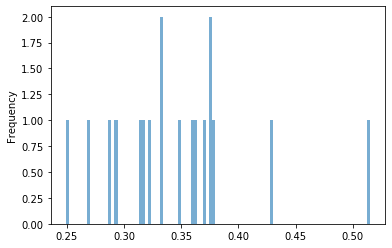

In [17]:
df_inclusive_subset['EigValuesReal_2'].plot.hist(bins=100, alpha=0.6)

<function matplotlib.pyplot.show(*args, **kw)>

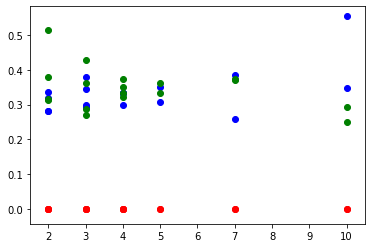

In [18]:
plt.scatter(df_inclusive_subset['<pT>'],df_inclusive_subset['EigValuesReal_0'],c='Red')
plt.scatter(df_inclusive_subset['<pT>'],df_inclusive_subset['EigValuesReal_1'],c='Blue')
plt.scatter(df_inclusive_subset['<pT>'],df_inclusive_subset['EigValuesReal_2'],c='Green')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

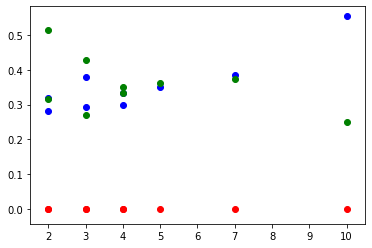

In [19]:
df_HE = df_inclusive_subset[df_inclusive_subset['Frame'] < 0.5]



plt.scatter(df_HE['<pT>'],df_HE['EigValuesReal_0'],c='Red')
plt.scatter(df_HE['<pT>'],df_HE['EigValuesReal_1'],c='Blue')
plt.scatter(df_HE['<pT>'],df_HE['EigValuesReal_2'],c='Green')
plt.show



<function matplotlib.pyplot.show(*args, **kw)>

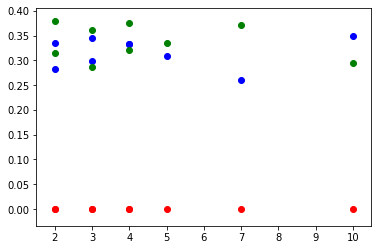

In [20]:
df_CS = df_inclusive_subset[df_inclusive_subset['Frame'] > 0.5]



plt.scatter(df_CS['<pT>'],df_CS['EigValuesReal_0'],c='Red')
plt.scatter(df_CS['<pT>'],df_CS['EigValuesReal_1'],c='Blue')
plt.scatter(df_CS['<pT>'],df_CS['EigValuesReal_2'],c='Green')
plt.show



In [21]:
def ProbeMatrixWithUncert( Rho11, Rho13, Rho22, Rho33, returnValue ):
    rho       = np.array([[uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.)], 
                          [uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.)],
                          [uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.),uncertainties.ufloat(0.,0.)]])
    rho[0][0] = Rho11
    rho[0][2] = Rho13
    rho[2][0] = Rho13
    rho[1][1] = Rho22
    rho[2][2] = Rho33
    if returnValue == 0:
        return rho 
    elif returnValue == 1:
        return rho[0][0]
    elif returnValue == 2:
        return rho[0][1]
    elif returnValue == 3:
        return rho[0][2]
    elif returnValue == 4:
        return rho[0][3]
    elif returnValue == 5:
        return rho[1][0]
    elif returnValue == 6:
        return rho[1][1]
    elif returnValue == 7:
        return rho[1][2]
    elif returnValue == 8:
        return rho[2][0]
    elif returnValue == 9:
        return rho[2][1]
    elif returnValue == 10:
        return rho[2][2]



In [22]:
df_inclusive['ProbeMatrixUncert'] = df_inclusive.apply(lambda x: ProbeMatrixWithUncert( x['Rho11withuncert'], x['Rho13withuncert'], x['Rho22withuncert'], x['Rho33withuncert'], 0 ), axis=1)
df_inclusive


,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho22withuncert,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,ProbeMatrixUncert
0,7,0,2.0,-0.360,0.050,0.000,0.090,0.040,0.000,0.210,...,0.28+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2803030303030303, 0...","[0.0, 0.2803030303030303, 0.515151515151515]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.280303,0.515152,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.28+..."
1,7,0,3.0,-0.200,0.010,0.000,0.110,0.050,0.000,0.130,...,0.29+/-0.05,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29285714285714287, ...","[0.0, 0.29285714285714287, 0.4285714285714286]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.292857,0.428571,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.29+..."
2,7,0,4.0,0.000,0.000,0.000,0.100,0.040,0.000,0.100,...,0.33+/-0.04,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3333333333333333]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.333333,0.333333,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.33+..."
3,7,1,2.0,-0.100,-0.040,0.000,0.140,0.080,0.000,0.130,...,0.28+/-0.07,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2827586206896552, 0...","[0.0, 0.2827586206896552, 0.37931034482758624]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.282759,0.379310,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.28+..."
4,7,1,3.0,-0.060,-0.030,0.000,0.140,0.080,0.000,0.070,...,0.30+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29931972789115646, ...","[0.0, 0.29931972789115646, 0.36054421768707484]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.299320,0.360544,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.30+..."
5,7,1,4.0,-0.090,0.030,0.000,0.100,0.060,0.000,0.080,...,0.33+/-0.06,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3745704467353952]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.333333,0.374570,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.33+..."
6,8,0,2.0,0.035,-0.037,-0.024,0.048,0.025,0.032,0.215,...,0.32+/-0.06,0.02+/-0.06,0.001+/-0.006,"[[0.0007866770236703058, 0.0, 0.01581548599670...","[0.0, 0.3187438434157625, 0.31663920922570016]","[[-0.9987652106382785, -0.049679513068018016, ...",0.000000e+00,0.318744,0.316639,"[[0.001+/-0.006, 0.0+/-0, 0.02+/-0.06], [0.0+/..."
7,8,0,3.0,-0.085,-0.065,-0.080,0.053,0.026,0.035,0.189,...,0.27+/-0.09,0.05+/-0.06,0.008+/-0.017,"[[0.008094157820268594, 0.0, 0.054888507718696...","[5.551115123125783e-17, 0.38030685078767856, 0...","[[-0.9893011528018606, -0.1458877276021177, 0....",5.551115e-17,0.380307,0.269297,"[[0.008+/-0.017, 0.0+/-0, 0.05+/-0.06], [0.0+/..."
8,8,0,4.0,0.083,-0.003,-0.024,0.066,0.033,0.043,0.188,...,0.35+/-0.07,0.02+/-0.06,0.001+/-0.006,"[[0.0008149662323127745, 0.0, 0.01556925072980...","[-5.551115123125783e-17, 0.2982525270496984, 0...","[[-0.9986328301723268, -0.0522730380024773, 0....",-5.551115e-17,0.298253,0.349335,"[[0.001+/-0.006, 0.0+/-0, 0.02+/-0.06], [0.0+/..."
9,8,0,5.0,-0.036,0.055,-0.001,0.058,0.029,0.039,0.154,...,0.36+/-0.05,0.00+/-0.06,0.00000+/-0.00023,"[[1.30263288158025e-06, 0.0, 0.000674763832658...","[-5.551115123125783e-17, 0.3495289679500206, 0...","[[-0.9999981365863567, -0.0019304983331782945,...",-5.551115e-17,0.349529,0.362348,"[[0.00000+/-0.00023, 0.0+/-0, 0.00+/-0.06], [0..."


In [23]:
# df_inclusive[['EigValuesWithUncert','EigVecsWithUncert']] = df_inclusive.apply(lambda x: eig(x['ProbeMatrixUncert']  ), axis=1, result_type="expand")


In [24]:
import scipy

In [25]:
# df_inclusive['LogRho'] = df_inclusive.apply(lambda x: scipy.linalg.logm(x['ProbeMatrix']  ), axis=1, result_type="expand")
df_inclusive['Trace'] = df_inclusive.apply(lambda x: np.trace(x['ProbeMatrix']*x['ProbeMatrix']  ), axis=1, result_type="expand")
df_inclusive

,E,Frame,<pT>,Ltheta,Lphi,Lthetaphi,StatLtheta,StatLphi,StatLthetaphi,SysLtheta,...,Rho13withuncert,Rho11withuncert,ProbeMatrix,EigValues,EigVecs,EigValuesReal_0,EigValuesReal_1,EigValuesReal_2,ProbeMatrixUncert,Trace
0,7,0,2.0,-0.360,0.050,0.000,0.090,0.040,0.000,0.210,...,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2803030303030303, 0...","[0.0, 0.2803030303030303, 0.515151515151515]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.280303,0.515152,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.28+...",0.343951
1,7,0,3.0,-0.200,0.010,0.000,0.110,0.050,0.000,0.130,...,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29285714285714287, ...","[0.0, 0.29285714285714287, 0.4285714285714286]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.292857,0.428571,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.29+...",0.269439
2,7,0,4.0,0.000,0.000,0.000,0.100,0.040,0.000,0.100,...,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3333333333333333]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.333333,0.333333,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.33+...",0.222222
3,7,1,2.0,-0.100,-0.040,0.000,0.140,0.080,0.000,0.130,...,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.2827586206896552, 0...","[0.0, 0.2827586206896552, 0.37931034482758624]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.282759,0.379310,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.28+...",0.223829
4,7,1,3.0,-0.060,-0.030,0.000,0.140,0.080,0.000,0.070,...,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.29931972789115646, ...","[0.0, 0.29931972789115646, 0.36054421768707484]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.299320,0.360544,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.30+...",0.219584
5,7,1,4.0,-0.090,0.030,0.000,0.100,0.060,0.000,0.080,...,-0.0+/-0,0.0+/-0,"[[0.0, 0.0, -0.0], [0.0, 0.3333333333333333, 0...","[0.0, 0.3333333333333333, 0.3745704467353952]","[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, ...",0.000000e+00,0.333333,0.374570,"[[0.0+/-0, 0.0+/-0, -0.0+/-0], [0.0+/-0, 0.33+...",0.251414
6,8,0,2.0,0.035,-0.037,-0.024,0.048,0.025,0.032,0.215,...,0.02+/-0.06,0.001+/-0.006,"[[0.0007866770236703058, 0.0, 0.01581548599670...","[0.0, 0.3187438434157625, 0.31663920922570016]","[[-0.9987652106382785, -0.049679513068018016, ...",0.000000e+00,0.318744,0.316639,"[[0.001+/-0.006, 0.0+/-0, 0.02+/-0.06], [0.0+/...",0.201358
7,8,0,3.0,-0.085,-0.065,-0.080,0.053,0.026,0.035,0.189,...,0.05+/-0.06,0.008+/-0.017,"[[0.008094157820268594, 0.0, 0.054888507718696...","[5.551115123125783e-17, 0.38030685078767856, 0...","[[-0.9893011528018606, -0.1458877276021177, 0....",5.551115e-17,0.380307,0.269297,"[[0.008+/-0.017, 0.0+/-0, 0.05+/-0.06], [0.0+/...",0.211129
8,8,0,4.0,0.083,-0.003,-0.024,0.066,0.033,0.043,0.188,...,0.02+/-0.06,0.001+/-0.006,"[[0.0008149662323127745, 0.0, 0.01556925072980...","[-5.551115123125783e-17, 0.2982525270496984, 0...","[[-0.9986328301723268, -0.0522730380024773, 0....",-5.551115e-17,0.298253,0.349335,"[[0.001+/-0.006, 0.0+/-0, 0.02+/-0.06], [0.0+/...",0.210505
9,8,0,5.0,-0.036,0.055,-0.001,0.058,0.029,0.039,0.154,...,0.00+/-0.06,0.00000+/-0.00023,"[[1.30263288158025e-06, 0.0, 0.000674763832658...","[-5.551115123125783e-17, 0.3495289679500206, 0...","[[-0.9999981365863567, -0.0019304983331782945,...",-5.551115e-17,0.349529,0.362348,"[[0.00000+/-0.00023, 0.0+/-0, 0.00+/-0.06], [0...",0.253466


In [26]:
# df_inclusive['Degree'] = df_inclusive.apply(lambda x: math.sqrt(1.5*x['Trace']-0.5)  , axis=1, result_type="expand")
# df_inclusive
print(df_inclusive['Rho11'])

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000787
7     0.008094
8     0.000815
9     0.000001
10    0.009978
11    0.055535
12    0.002244
13    0.007446
14    0.000048
15    0.002459
16    0.000124
17    0.005556
Name: Rho11, dtype: float64


In [27]:
print(df_inclusive['Rho22'])

0     0.280303
1     0.292857
2     0.333333
3     0.282759
4     0.299320
5     0.333333
6     0.316639
7     0.269297
8     0.349335
9     0.362348
10    0.374140
11    0.248970
12    0.313791
13    0.287387
14    0.320893
15    0.333986
16    0.370709
17    0.293723
Name: Rho22, dtype: float64


In [28]:
print(df_inclusive['Rho33'])

0     0.515152
1     0.428571
2     0.333333
3     0.379310
4     0.360544
5     0.374570
6     0.317957
7     0.372213
8     0.297438
9     0.349528
10    0.375516
11    0.497566
12    0.332445
13    0.338240
14    0.332889
15    0.305909
16    0.259843
17    0.342732
Name: Rho33, dtype: float64


In [29]:
print(df_inclusive['Rho13'])

0    -0.000000
1    -0.000000
2    -0.000000
3    -0.000000
4    -0.000000
5    -0.000000
6     0.015815
7     0.054889
8     0.015569
9     0.000675
10   -0.061210
11   -0.166230
12   -0.027315
13    0.050184
14   -0.003999
15    0.027424
16    0.005669
17    0.043639
Name: Rho13, dtype: float64
